In [2]:
import pnadium

pnadium.trimestral.download(2024, 4)

Iniciou o download: Trimestre 4/2024 - aguarde.
Download finalizado.
Iniciou a criação do DataFrame Pandas: esta etapa pode demorar alguns minutos.
Chunks processados e salvos.
DataFrame criado.
DataFrame "pnad_trimestral_trimestre_042024.parquet" salvo como arquivo Parquet em: /home/godofthemast/Meus_Scripts/insper/cdados/exercicios/analisedadosPNADcont/pnad_trimestral_trimestre_042024.parquet


In [2]:
import pandas as pd

dados = pd.read_parquet('pnad_trimestral_trimestre_042024.parquet')
dados.head()


,Ano,Trimestre,UF,Capital,RM_RIDE,UPA,Estrato,V1008,V1014,V1016,...,V1028193,V1028194,V1028195,V1028196,V1028197,V1028198,V1028199,V1028200,COD_FAM,COD_PESSOA
0,2024,4,11,11.0,NaN,110000016,1110011,02,11,4,...,957.197334,0.0,778.285822,0.0,256.600053,0.0,0.0,283.755315,1100000160211,110000016021101
1,2024,4,11,11.0,NaN,110000016,1110011,02,11,4,...,957.197334,0.0,778.285822,0.0,256.600053,0.0,0.0,283.755315,1100000160211,110000016021102
2,2024,4,11,11.0,NaN,110000016,1110011,03,11,4,...,764.380448,0.0,622.196312,0.0,210.777094,0.0,0.0,214.602823,1100000160311,110000016031101
3,2024,4,11,11.0,NaN,110000016,1110011,03,11,4,...,764.380448,0.0,622.196312,0.0,210.777094,0.0,0.0,214.602823,1100000160311,110000016031102
4,2024,4,11,11.0,NaN,110000016,1110011,03,11,4,...,764.380448,0.0,622.196312,0.0,210.777094,0.0,0.0,214.602823,1100000160311,110000016031103


In [3]:
import numpy as np

# 1. Identificação das variáveis relevantes e Cálculo da Renda Per Capita (conforme instruções)

# Certificar que as colunas UPA, V1008, V1014 são do tipo string para concatenação
dados['UPA'] = dados['UPA'].astype(str)
dados['V1008'] = dados['V1008'].astype(str)
dados['V1014'] = dados['V1014'].astype(str)

# Criar a variável 'id_domicilio'
dados['id_domicilio'] = dados['UPA'] + dados['V1008'] + dados['V1014']

# Agrupar por 'id_domicilio' para calcular a renda total e o número de moradores
domicilio_agg = dados.groupby('id_domicilio').agg(
    # Usando VD4019 conforme instruído, mas com ressalvas.
    renda_total_domicilio=('VD4019', 'sum'),
    num_moradores=('id_domicilio', 'size')
)

# Calcular a renda per capita por domicílio
domicilio_agg['renda_per_capita_calculada'] = np.where(
    domicilio_agg['num_moradores'] > 0,
    domicilio_agg['renda_total_domicilio'] / domicilio_agg['num_moradores'],
    0
)

# Juntar a renda per capita calculada de volta ao dataframe original de pessoas
dados = dados.merge(
    domicilio_agg[['renda_per_capita_calculada']],
    on='id_domicilio',
    how='left'
)

# Calcular a média ponderada da renda per capita calculada
# Remover NaNs que podem surgir de merge ou na coluna de peso antes de calcular a média
dados_validos = dados.dropna(subset=['renda_per_capita_calculada', 'V1028'])
renda_media_per_capita_ponderada = np.average(
    dados_validos['renda_per_capita_calculada'],
    weights=dados_validos['V1028']
)

print(f"Renda Média Per Capita Ponderada: R$ {renda_media_per_capita_ponderada:.2f}")

# Exibir algumas colunas relevantes para verificação
print("\nDataFrame com a coluna 'renda_per_capita_calculada':")
print(dados[['UF', 'id_domicilio', 'VD4019', 'V1028', 'renda_per_capita_calculada']])

Renda Média Per Capita Ponderada: R$ 1560.60

DataFrame com a coluna 'renda_per_capita_calculada':
        UF   id_domicilio  VD4019       V1028  renda_per_capita_calculada
0       11  1100000160211     NaN  247.706465                  706.000000
1       11  1100000160211  1412.0  247.706465                  706.000000
2       11  1100000160311  1412.0  195.875282                  853.000000
3       11  1100000160311  2000.0  195.875282                  853.000000
4       11  1100000160311     NaN  195.875282                  853.000000
...     ..            ...     ...         ...                         ...
469329  53  5300641231212  2100.0  277.663471                 1966.666667
469330  53  5300641231212  2000.0  277.663471                 1966.666667
469331  53  5300641231212  1800.0  277.663471                 1966.666667
469332  53  5300641231412     NaN  206.195599                    0.000000
469333  53  5300641231412     NaN  206.195599                    0.000000

[469334 rows

In [4]:
# 2. Definição da linha de pobreza

# Salário mínimo vigente no 4º trimestre de 2024 (vigente desde 01/01/2024)
salario_minimo_2024 = 1412.00

# Definir a linha de pobreza como meio salário mínimo
linha_pobreza = salario_minimo_2024 / 2

print(f"Salário Mínimo (4º Tri 2024): R$ {salario_minimo_2024:.2f}")
print(f"Linha de Pobreza (1/2 SM): R$ {linha_pobreza:.2f}")

dados['pobre'] = np.where(dados['VD4019'] < linha_pobreza, 1, 0)

# Verificar a criação da coluna e os primeiros valores
print("\nDataFrame com a coluna 'pobre':")
print(dados[['UF', 'VD4019', 'pobre']])

# Verificar a contagem de pobres e não pobres (incluindo NaNs em VD4019 que resultaram em 'pobre'=0)
print("\nContagem inicial na coluna 'pobre':")
print(dados['pobre'].value_counts(dropna=False))

Salário Mínimo (4º Tri 2024): R$ 1412.00
Linha de Pobreza (1/2 SM): R$ 706.00

DataFrame com a coluna 'pobre':
        UF  VD4019  pobre
0       11     NaN      0
1       11  1412.0      0
2       11  1412.0      0
3       11  2000.0      0
4       11     NaN      0
...     ..     ...    ...
469329  53  2100.0      0
469330  53  2000.0      0
469331  53  1800.0      0
469332  53     NaN      0
469333  53     NaN      0

[469334 rows x 3 columns]

Contagem inicial na coluna 'pobre':
pobre
0    444157
1     25177
Name: count, dtype: int64


In [7]:
import numpy as np
def bootstrap_ci(df, col, weight_col, n_bootstrap=1000, alpha=0.05):

    """Calcula estatística (média ou proporção ponderada) e intervalo de confiança usando
    bootstrap.

    Parâmetros:
    ----------
    df : DataFrame
    DataFrame contendo os dados
    col : str
    Nome da coluna com a variável numérica (pode ser 0/1 ou contínua)
    weight_col : str
    Nome da coluna contendo os pesos amostrais
    n_bootstrap : int, opcional
    Número de amostras bootstrap (padrão: 1000)
    alpha : float, opcional
    Nível de significância (padrão: 0.05 para IC de 95%)

    Retorna:
    -------
    float, tuple
    Estatística ponderada original e tupla com limites inferior e superior do IC"""

    # Estatística original (proporção ou média ponderada)
    stat_original = np.average(df[col], weights=df[weight_col])

    # Estimativas bootstrap
    estimates = []

    for _ in range(n_bootstrap):
        sample = df.sample(frac=1, replace=True)
        stat = np.average(sample[col], weights=sample[weight_col])
        estimates.append(stat)

    # Intervalo de confiança
    lower = np.percentile(estimates, 100 * alpha / 2)
    upper = np.percentile(estimates, 100 * (1- alpha / 2))

    return stat_original, (lower, upper)

In [8]:
# 3. Cálculo da proporção para suas regiões

# Filtrar dados para remover NaNs em VD4019 (que afeta 'pobre') e V1028 (peso)
# Pessoas com VD4019 NaN não podem ser classificadas como pobres/não pobres
dados_validos_pobreza = dados.dropna(subset=['VD4019', 'V1028'])

# Verificar o número de observações válidas
print(f"Número de observações válidas para análise de pobreza: {len(dados_validos_pobreza)}")

# Calcular a proporção ponderada e o IC de 95% usando bootstrap
proporcao_pobreza, ic_pobreza = bootstrap_ci(
    df=dados_validos_pobreza,
    col='pobre',
    weight_col='V1028',
    n_bootstrap=1000,  # Número de réplicas bootstrap (pode ajustar se necessário)
    alpha=0.05         # Para IC de 95%
)

# Expressar como percentagem
proporcao_pobreza_perc = proporcao_pobreza * 100
ic_pobreza_perc = (ic_pobreza[0] * 100, ic_pobreza[1] * 100)

print(f"\nProporção Ponderada de Pessoas Abaixo da Linha de Pobreza: {proporcao_pobreza_perc:.2f}%")
print(f"Intervalo de Confiança de 95% (Bootstrap): ({ic_pobreza_perc[0]:.2f}%, {ic_pobreza_perc[1]:.2f}%)")

Número de observações válidas para análise de pobreza: 204334

Proporção Ponderada de Pessoas Abaixo da Linha de Pobreza: 9.54%
Intervalo de Confiança de 95% (Bootstrap): (9.39%, 9.69%)


In [ ]:
# 4. Cálculo da proporção por UF

ufs = dados_validos_pobreza['UF'].unique()
ufs.sort() # Ordenar UFs para melhor visualização

resultados_uf = []

print("\nCalculando proporção de pobreza por UF (pode levar alguns minutos)...")

for uf in ufs:
    dados_uf = dados_validos_pobreza[dados_validos_pobreza['UF'] == uf]

    # Verificar se há dados suficientes na UF para calcular
    if len(dados_uf) > 1: # Precisa de mais de 1 obs para bootstrap razoável
        proporcao_uf, ic_uf = bootstrap_ci(
            df=dados_uf,
            col='pobre',
            weight_col='V1028',
            n_bootstrap=500,  # Reduzir n_bootstrap se for muito lento, mas 1000 é ideal
            alpha=0.05
        )
        resultados_uf.append({
            'UF': uf,
            'Proporcao_Pobreza (%)': proporcao_uf * 100,
            'IC_Inferior (%)': ic_uf[0] * 100,
            'IC_Superior (%)': ic_uf[1] * 100
        })
    else:
         resultados_uf.append({
            'UF': uf,
            'Proporcao_Pobreza (%)': np.nan,
            'IC_Inferior (%)': np.nan,
            'IC_Superior (%)': np.nan
        })

# Criar DataFrame com os resultados
resultados_uf_df = pd.DataFrame(resultados_uf)

# Exibir os resultados formatados
print("\nProporção de Pessoas Abaixo da Linha de Pobreza por UF (com IC 95%):")
# Formatar colunas numéricas para melhor leitura
pd.set_option('display.float_format', '{:.2f}'.format)
print(resultados_uf_df.round(2))


Calculando proporção de pobreza por UF (pode levar alguns minutos)...

Proporção de Pessoas Abaixo da Linha de Pobreza por UF (com IC 95%):
    UF  Proporcao_Pobreza (%)  IC_Inferior (%)  IC_Superior (%)
0   11                   7.15             6.09             8.26
1   12                  13.41            12.20            14.65
2   13                  15.56            14.40            16.70
3   14                  10.52             9.31            11.81
4   15                  18.89            17.83            19.96
5   16                   8.75             7.43            10.14
6   17                   9.99             8.95            11.19
7   21                  23.39            22.55            24.20
8   22                  25.25            23.58            26.87
9   23                  22.74            21.78            23.76
10  24                  17.06            15.55            18.42
11  25                  20.51            19.28            21.87
12  26                  20.

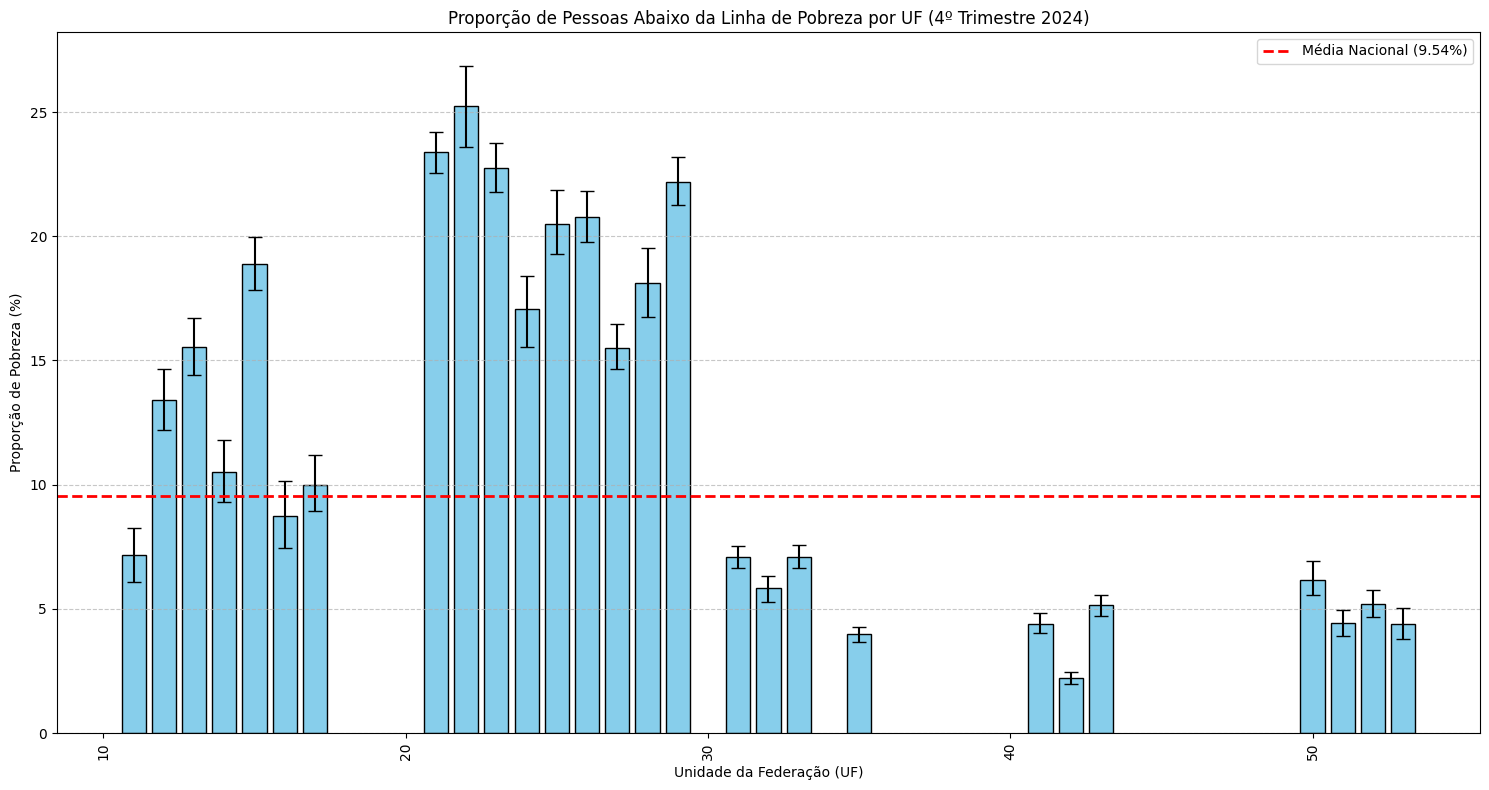

In [10]:
import matplotlib.pyplot as plt

# 5. Visualização dos resultados

# Ordenar o DataFrame pela proporção de pobreza (decrescente)
resultados_uf_df_sorted = resultados_uf_df.sort_values('Proporcao_Pobreza (%)', ascending=False)

# Calcular o tamanho do erro para as barras (metade da largura do IC)
# IC = [IC_Inferior, IC_Superior]
# Ponto central = Proporcao_Pobreza
# Erro para cima = IC_Superior - Proporcao_Pobreza
# Erro para baixo = Proporcao_Pobreza - IC_Inferior
# Usaremos um formato que o `yerr` do matplotlib entende: [erro_abaixo, erro_acima]
erro_inferior = resultados_uf_df_sorted['Proporcao_Pobreza (%)'] - resultados_uf_df_sorted['IC_Inferior (%)']
erro_superior = resultados_uf_df_sorted['IC_Superior (%)'] - resultados_uf_df_sorted['Proporcao_Pobreza (%)']
erros_ic = [erro_inferior.to_numpy(), erro_superior.to_numpy()] # Precisa ser array para yerr

# Criar o gráfico de barras
plt.figure(figsize=(15, 8)) # Ajustar tamanho para melhor visualização
bars = plt.bar(
    resultados_uf_df_sorted['UF'],
    resultados_uf_df_sorted['Proporcao_Pobreza (%)'],
    yerr=erros_ic,
    capsize=5, # Adiciona 'caps' às barras de erro
    color='skyblue',
    edgecolor='black'
)

# Adicionar linha horizontal para a média nacional (calculada na etapa 3)
plt.axhline(
    y=proporcao_pobreza_perc,
    color='r',
    linestyle='--',
    linewidth=2,
    label=f'Média Nacional ({proporcao_pobreza_perc:.2f}%)'
)

# Melhorar a visualização
plt.xlabel('Unidade da Federação (UF)')
plt.ylabel('Proporção de Pobreza (%)')
plt.title('Proporção de Pessoas Abaixo da Linha de Pobreza por UF (4º Trimestre 2024)')
plt.xticks(rotation=90) # Rotacionar labels do eixo X para evitar sobreposição
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Ajustar layout para não cortar labels

# Exibir o gráfico
plt.show()